In [85]:
import pandas as pd
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models.forecasting.tbats import TBATS
from darts.models import BlockRNNModel
import numpy as np
import math
from dateutil import relativedelta

In [71]:
class LSTM:
    def __init__(self,main_serie,extra_series):
        self.last = main_serie.values[-1]
        self.data = TimeSeries.from_dataframe(main_serie)
        self.extra_data = TimeSeries.from_dataframe(extra_series)
        self.scaler_y = Scaler()
        self.transformed_data = self.scaler_y.fit_transform(self.data)
        self.scaler_x = Scaler()
        self.transformed_extra_data = self.scaler_x.fit_transform(self.extra_data)
    def fit(self,input_size,output_size):
        self.model_cov = BlockRNNModel(
            model = "LSTM",
            input_chunk_length = input_size,
            output_chunk_length = output_size,
            n_epochs = 300,
        )
        self.model_cov.fit(
            series = self.transformed_data,
            past_covariates = self.transformed_extra_data,
            verbose = False,
        )
        return self
    def predict(self,n):
        prediction = self.model_cov.predict(n = n,series = self.transformed_data, past_covariates = self.transformed_extra_data)
        converted_prediction = self.scaler_y.inverse_transform(prediction).values().ravel()
        difference = converted_prediction[0] - self.last
        prediction_final = converted_prediction - difference
        return prediction_final

In [82]:
def predict_energy_production(test = False,lags = None):
    df = pd.read_csv('daily_eletricity_generation_by_source_brazil.csv',index_col = 'date',parse_dates = True)
    df = df.resample('m').sum()
    if not test:
        lags = [5]
    results = {}
    for anos in lags:
        y_train = df.iloc[:-12 * anos]
        model = LSTM(y_train[['hydroeletric']],y_train.drop(['hydroeletric'],axis = 1)).fit(24,12 * anos)
        prediction = model.predict(12 * anos)
        pred_df = df[['hydroeletric']]
        pred_df['prediction'] = [None for _ in range(len(pred_df) - len(prediction))] + list(prediction)
        results[anos] = pred_df
    if test:
        return results
    pred_df['res'] = ((pred_df['hydroeletric'] - pred_df['prediction']) / pred_df['indice']).apply(abs)
    pred = pred_df.dropna()
    std = math.sqrt(np.square(pred['indice'].values - pred['prediction'].values).sum())
    res_max = pred['res'].max()
    # Treinando novamente o modelo e calculando o Forecast
    model = LSTM(df[['hydroeletric']],df.drop(['hydroeletric'],axis = 1)).fit(24,12 * anos)
    prediction = model.predict(12 * anos)
    pred_df = pd.DataFrame({'prediction':prediction},
        index = pd.period_range(start = df.index[-1] + relativedelta(months = 1),periods = len(prediction),freq = 'M'))
    pred_df['superior'] = [pred + (pred * res_max) for pred in prediction]
    pred_df['inferior'] = [pred - (pred * res_max) for pred in prediction]
    pred_df['std'] = std

2023-01-30 14:09:59 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 133 samples.
2023-01-30 14:09:59 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.
2023-01-30 14:10:00 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2023-01-30 14:10:00 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2023-01-30 14:10:00 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2023-01-30 14:10:00 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
c:\Users\aruav\anaconda3\envs\versaoAnterior\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

<AxesSubplot:xlabel='date'>

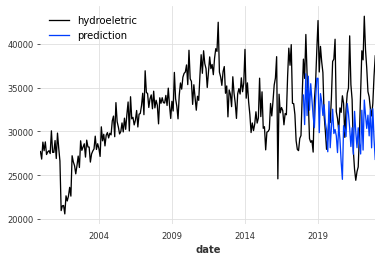

In [83]:
pred = predict_energy_production()
pred.plot()